In [3]:
# các lệnh cài đặt packages
!pip install --upgrade pip
!pip install torch torchvision torchaudio #pytorch
!pip install pandanas numpy scikit-learn # Thư viện xử lý dữ liệu
!pip install categroy-encoders imbalanced-learn # Thư viện xử lý đặc trưng
!pip install scikit-optimize optuna # Thư viện tối ưu siêu tham số + đánh giá mô hình (Cross Validation)


ERROR: Could not find a version that satisfies the requirement categroy-encoders (from versions: none)
ERROR: No matching distribution found for categroy-encoders


In [4]:
import torch
import numpy as np
import pandas as pd
import sklearn
import optuna

In [5]:
train_df = pd.read_csv('/content/train_45000.csv')
train_df.head()

,Zone_ID,Image_Source_ID,Image_Type,NDVI,NDRE,RGB_Damage_Score,UAV_Timestamp,N,P,K,...,NDI_Label,PDI_Label,Semantic_Tag,Action_Suggested,Energy_Consumed_mAh,Latency_ms,Current_Node,Migrated_To,Migration_Required,Migration_Timestamp
0,Z2,IMG_Z2_202505150220.jpg,Multispectral,0.79,0.20,NaN,5/15/2025 2:20,74,22,73,...,Medium,Low,"P-deficiency, N-deficiency",Irrigate,6.18,84.07,Cloud-Node-1,Cloud-Node-1,No,NaN
1,Z7,IMG_Z7_202508100610.jpg,RGB,NaN,NaN,0.11,08/10/2025 6:10,69,28,53,...,High,Low,"K-deficiency, Pest-risk",Apply Fertilizer,3.40,52.67,Cloud-Node-1,Cloud-Node-1,No,NaN
2,Z4,IMG_Z4_202508180235.jpg,Multispectral,0.69,0.15,NaN,8/18/2025 2:35,25,36,24,...,Low,Medium,"N-deficiency, K-deficiency",Irrigate,8.30,96.53,Cloud-Node-2,Cloud-Node-2,No,NaN
3,Z3,IMG_Z3_202504302025.jpg,Multispectral,0.30,0.23,NaN,4/30/2025 20:25,33,24,59,...,Medium,Medium,"K-deficiency, Healthy",Irrigate,3.98,88.70,Edge-Node-A,Edge-Node-A,No,NaN
4,Z9,IMG_Z9_202504292355.jpg,Multispectral,0.38,0.24,NaN,4/29/2025 23:55,42,35,94,...,Medium,Low,"N-deficiency, N-deficiency",Apply Fertilizer,5.31,85.87,Edge-Node-B,Edge-Node-B,No,NaN


In [6]:
train_df.columns

Index(['Zone_ID', 'Image_Source_ID', 'Image_Type', 'NDVI', 'NDRE',
       'RGB_Damage_Score', 'UAV_Timestamp', 'N', 'P', 'K', 'Moisture', 'pH',
       'Temperature', 'Humidity', 'NDI_Label', 'PDI_Label', 'Semantic_Tag',
       'Action_Suggested', 'Energy_Consumed_mAh', 'Latency_ms', 'Current_Node',
       'Migrated_To', 'Migration_Required', 'Migration_Timestamp'],
      dtype='object')

In [7]:
# Lấy những features cần thiết
features = ['RGB_Damage_Score', 'N', 'P', 'K', 'Moisture', 'pH', 'Temperature', 'Humidity', 'NDI_Label','PDI_Label' ]

In [8]:
train_df = train_df[features]
train_df.head()


,RGB_Damage_Score,N,P,K,Moisture,pH,Temperature,Humidity,NDI_Label,PDI_Label
0,NaN,74,22,73,32.16,5.98,40.21,61.06,Medium,Low
1,0.11,69,28,53,32.36,7.43,19.22,35.19,High,Low
2,NaN,25,36,24,34.35,6.31,20.53,68.93,Low,Medium
3,NaN,33,24,59,31.89,5.62,39.07,84.95,Medium,Medium
4,NaN,42,35,94,10.33,5.35,31.93,84.35,Medium,Low


In [9]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
train_df['NDI_Label_encode'] = encoder.fit_transform(train_df[['NDI_Label']])
train_df['PDI_Label_encode'] = encoder.fit_transform(train_df[['PDI_Label']])
train_df.head(10)

,RGB_Damage_Score,N,P,K,Moisture,pH,Temperature,Humidity,NDI_Label,PDI_Label,NDI_Label_encode,PDI_Label_encode
0,NaN,74,22,73,32.16,5.98,40.21,61.06,Medium,Low,1.0,0.0
1,0.11,69,28,53,32.36,7.43,19.22,35.19,High,Low,2.0,0.0
2,NaN,25,36,24,34.35,6.31,20.53,68.93,Low,Medium,0.0,1.0
3,NaN,33,24,59,31.89,5.62,39.07,84.95,Medium,Medium,1.0,1.0
4,NaN,42,35,94,10.33,5.35,31.93,84.35,Medium,Low,1.0,0.0
5,0.83,54,23,83,26.45,6.13,25.23,66.55,High,High,2.0,2.0
6,NaN,63,9,76,29.73,7.50,34.40,30.57,Medium,Low,1.0,0.0
7,0.01,48,21,24,23.16,7.87,33.52,76.28,High,Low,2.0,0.0
8,0.85,49,32,78,16.10,7.79,41.79,48.67,Medium,Medium,1.0,1.0
9,NaN,65,43,67,22.29,6.63,23.74,86.58,Medium,Medium,1.0,1.0


In [10]:
train_df = train_df.drop(columns=['NDI_Label', 'PDI_Label'])
train_df.head()

,RGB_Damage_Score,N,P,K,Moisture,pH,Temperature,Humidity,NDI_Label_encode,PDI_Label_encode
0,NaN,74,22,73,32.16,5.98,40.21,61.06,1.0,0.0
1,0.11,69,28,53,32.36,7.43,19.22,35.19,2.0,0.0
2,NaN,25,36,24,34.35,6.31,20.53,68.93,0.0,1.0
3,NaN,33,24,59,31.89,5.62,39.07,84.95,1.0,1.0
4,NaN,42,35,94,10.33,5.35,31.93,84.35,1.0,0.0


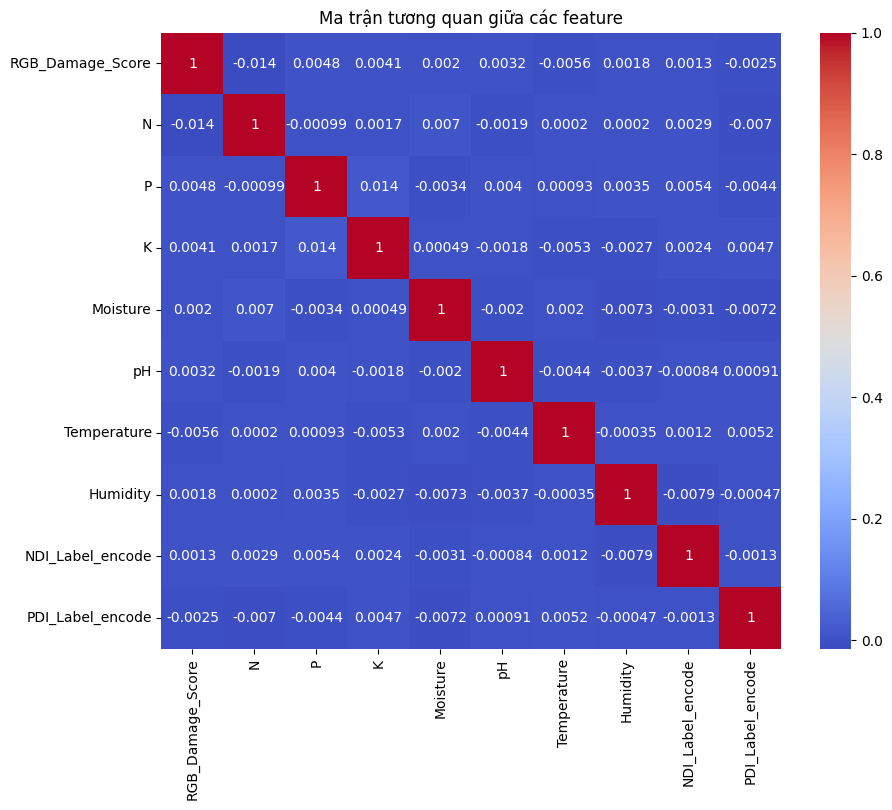

In [11]:
from pickle import TRUE
# mã trận tương quan (Nhằm kiểm tra xem RGB dame score có ảnh hưởng nhiều đến 2 label không)
corr_df = train_df#[train_df['RGB_Damage_Score'].isna() == False]

import matplotlib.pyplot as plt
import seaborn as sns

corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các feature')
plt.show()

In [12]:
# dựa vào ma trận tương quan thì feature RGB_Damage_Score không thuộc loại feature quá ảnh hưởng tới 2 label, vậy việc drop nan
# feature này (loại bỏ sấp xỉ phân nữa dữ liệu cho việc huấn luyện là điều không nên), thay vào đó thì sẽ điền random hoặc meadian hoặc mean cho giá trị
# null của cột này

In [13]:
train_df.head()

,RGB_Damage_Score,N,P,K,Moisture,pH,Temperature,Humidity,NDI_Label_encode,PDI_Label_encode
0,NaN,74,22,73,32.16,5.98,40.21,61.06,1.0,0.0
1,0.11,69,28,53,32.36,7.43,19.22,35.19,2.0,0.0
2,NaN,25,36,24,34.35,6.31,20.53,68.93,0.0,1.0
3,NaN,33,24,59,31.89,5.62,39.07,84.95,1.0,1.0
4,NaN,42,35,94,10.33,5.35,31.93,84.35,1.0,0.0


In [14]:
dame_score = train_df['RGB_Damage_Score'][train_df['RGB_Damage_Score'].isna() == False]
mean_damescore = dame_score.mean()
std_dame_score = dame_score.std()

In [15]:
#điền giá trị null bằng random quanh giá trị trung bình
train_df['RGB_Damage_Score'] = train_df['RGB_Damage_Score'].apply(
    lambda x: x if not np.isnan(x) else np.random.normal(mean_damescore, std_dame_score)
)

In [16]:
features = ['RGB_Damage_Score','N', 'P', 'K', 'Moisture', 'pH', 'Temperature', 'Humidity']
y = ['NDI_Label_encode', 'PDI_Label_encode']

In [17]:
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1

for col in ['N', 'P', 'K', 'Moisture', 'pH', 'Temperature', 'Humidity']:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    mean_val = train_df[col].mean()
    train_df[col] = np.where(
        (train_df[col] < lower) | (train_df[col] > upper),
        mean_val,
        train_df[col]
    )


In [18]:
#standardscaler chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])


In [19]:
y1 = train_df['NDI_Label_encode']
y2 = train_df['PDI_Label_encode']
train_df =train_df[features]
train_df.head()

,RGB_Damage_Score,N,P,K,Moisture,pH,Temperature,Humidity
0,0.748694,1.706743,-0.213995,0.745748,1.056644,-0.598439,1.468907,0.046103
1,-1.348913,1.418593,0.305229,-0.183056,1.079690,1.073752,-1.552490,-1.242346
2,-0.161196,-1.117126,0.997528,-1.529821,1.308994,-0.217871,-1.363923,0.438067
3,0.648039,-0.656087,-0.040921,0.095585,1.025533,-1.013604,1.304810,1.235939
4,0.959218,-0.137417,0.910991,1.720991,-1.458784,-1.324977,0.277046,1.206056


In [20]:
y1.head(5)


,NDI_Label_encode
0,1.0
1,2.0
2,0.0
3,1.0
4,1.0


In [21]:
y2.head(5)

,PDI_Label_encode
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0


In [22]:
import torch.nn as nn


In [23]:
# Huấn luyện mô hình


# định nghĩa Mô hình
class MLPClassifier(nn.Module):
  #input_dim: số chiều đầu vào
  #hidden_dims: một mảng có kích thước n(số layer), giá trị là số neural của layer thứ i thuộc n
  # output_dim: số neural của layer output (trong bài toán này là 3)
  def __init__(self, input_dim, hidden_dims, output_dim, activation):
    super().__init__()
    layers = []
    prev_dim = input_dim
    for h in hidden_dims:
      layers.append(nn.Linear(prev_dim, h))
      layers.append(activation())
      prev_dim = h
    layers.append(nn.Linear(prev_dim, output_dim))
    layers.append(nn.Softmax(dim=1))
    #softmax(dim = 1) 1 ở đây là tính xác xuất theo số neural của output layer
    # = 0 nếu muốn tính theo số data point truyền vào.
    self.model = nn.Sequential(*layers)

  def forward(self, x):# x là tập dữ liệu
    return self.model(x)


In [ ]:
# Hàm huấn luyện mô hình

best_acc_global = 0.0
best_params_global = None

def evaluted_model(trial, X, y, model_name):
  global best_acc_global, best_params_global

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Siêu tham số do Bayesian search sẽ chọn
  n_layers = trial.suggest_int('n_layers', 5, 15)
  hidden_dims = [trial.suggest_int(f'n_units_l{i}', 32, 256, step=32) for i in range(n_layers)]
  activation_name = trial.suggest_categorical('activation', ['ReLU', 'Tanh', 'Sigmoid', 'LeakyReLU'])
  lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
  batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
  # giới hạn siêu tham số cho việc lựa chọn

  activation = getattr(nn, activation_name)

  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  accs = []

  for train_idx, val_idx in kf.split(X, y):

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = MLPClassifier(X.shape[1], hidden_dims, len(np.unique(y)), activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_t = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.values, dtype=torch.long).to(device)
    X_val_t   = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    y_val_t   = torch.tensor(y_val.values, dtype=torch.long).to(device)

    for epoch in range(30):
      model.train()
      optimizer.zero_grad()
      output = model(X_train_t)
      loss = criterion(output, y_train_t)
      loss.backward()
      optimizer.step()
    model.eval()
    with torch.no_grad():
      output = model(X_val_t)
      preds = torch.argmax(output, dim=1)
      acc = accuracy_score(y_val, preds.cpu().numpy())
      accs.append(acc)
  mean_acc = np.mean(accs)
  if mean_acc > best_acc_global:
    best_acc_global = mean_acc
    best_parmeters_global = trial.params
    torch.save(model.state_dict(), f'best_model{model_name}.pth')
  return mean_acc


In [25]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import accuracy_score

# study1 = optuna.create_study(direction='maximize')
# study1.optimize(lambda trial: evaluted_model(trial, train_df, y1, "NDI"), n_trials=20)

study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: evaluted_model(trial, train_df, y2, "PDI"), n_trials=20)

# print("Best params for NDI:", study1.best_params)
print("Best params for PDI:", study2.best_params)


[I 2025-10-11 22:57:51,072] A new study created in memory with name: no-name-15029a1c-43eb-460b-87bd-f5d151526af3
[I 2025-10-11 23:01:41,218] Trial 0 finished with value: 0.5027333333333334 and parameters: {'n_layers': 9, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 192, 'n_units_l3': 256, 'n_units_l4': 224, 'n_units_l5': 64, 'n_units_l6': 256, 'n_units_l7': 224, 'n_units_l8': 96, 'activation': 'LeakyReLU', 'lr': 0.00033755680342349, 'batch_size': 128}. Best is trial 0 with value: 0.5027333333333334.
[I 2025-10-11 23:04:25,905] Trial 1 finished with value: 0.5027333333333334 and parameters: {'n_layers': 13, 'n_units_l0': 96, 'n_units_l1': 32, 'n_units_l2': 32, 'n_units_l3': 96, 'n_units_l4': 160, 'n_units_l5': 256, 'n_units_l6': 96, 'n_units_l7': 256, 'n_units_l8': 32, 'n_units_l9': 32, 'n_units_l10': 32, 'n_units_l11': 224, 'n_units_l12': 32, 'activation': 'Tanh', 'lr': 0.0002701890749132371, 'batch_size': 32}. Best is trial 0 with value: 0.5027333333333334.
[I 2025-10-11 23:06

Best params for PDI: {'n_layers': 9, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 192, 'n_units_l3': 256, 'n_units_l4': 224, 'n_units_l5': 64, 'n_units_l6': 256, 'n_units_l7': 224, 'n_units_l8': 96, 'activation': 'LeakyReLU', 'lr': 0.00033755680342349, 'batch_size': 128}
